# Matrix multiplication from scratch
In this series, we implement matrix multiplication from scratch. We are only allowed to use:
- python
- python standard library
- matplotlib
- Jupyter notebooks
However, once we have implemented a feature from scratch, we can use its Numpy/PyTorch equivalent.

In [1]:
from pathlib import Path
import pickle, gzip, math, os, time, shutil, matplotlib as mpl, matplotlib.pyplot as plt     

## Get data
We use the Fashion-MNIST in this notebook.

In [8]:
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [9]:
X_train, y_train = load_mnist('data/fashion', kind='train')
X_test, y_test = load_mnist('data/fashion', kind='t10k')

In [10]:
type(X_train)

numpy.ndarray

Since we are not allowed to use Numpy (yet), let's typecast the Numpy arrays back to lists.

In [11]:
X_train, y_train = list(X_train), list(y_train)
X_test, y_test = list(X_test), list(y_test)

In [12]:
len(X_train)

60000

In [13]:
len(X_train[0])

784

In [59]:
img = list(X_train[0])
type(img)

list

We have 60k images that are 784 (28*28) pixels each.

## Create iterators to convert 1D list (784) to 2D image (28 by 28)
We shall implement this using 2 methods:
1. `yield`
2. `itertools` `islice`

### `yield`

In [52]:
def chunks(arr, length):
    for i in range(0, len(arr), length):
        yield arr[i: i+length]

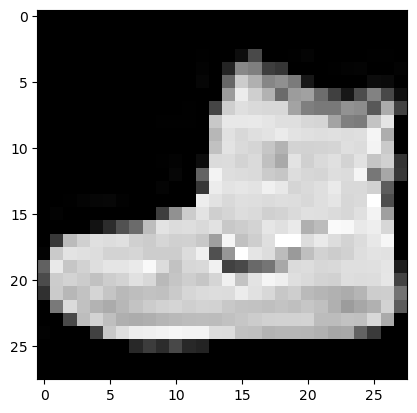

In [53]:
mpl.rcParams['image.cmap'] = 'gray'
plt.imshow(list(chunks(img, 28)))

### `islice`

In [60]:
from itertools import islice

In [61]:
img_iter = iter(img)

In [29]:
list(islice(img_iter, 28))

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [30]:
list(islice(img_iter, 28))

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [31]:
list(islice(img_iter, 28))

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [32]:
list(islice(img_iter, 28))

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 13,
 73,
 0,
 0,
 1,
 4,
 0,
 0,
 0,
 0,
 1,
 1,
 0]

We see that `islice` is working properly.

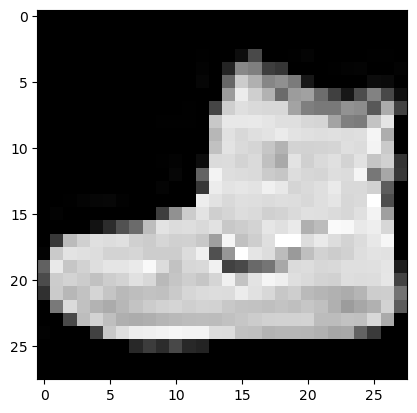

In [62]:
reshaped_img = list(iter(lambda: list(islice(img_iter, 28)), []))
plt.imshow(reshaped_img)

Now that we can reshape our python lists from 1D to 2D, we shall move on to implementing a Matrix class.

## Implementing Matrix class

In [44]:
class Matrix:
    def __init__(self, mat): self.mat = mat
    def __getitem__(self, idx): 
        i, j = idx
        return self.mat[i][j]

In [63]:
img_mat = Matrix(reshaped_img)

In [66]:
img_mat[7, 15]

223

We can now use PyTorch's tensor.

In [68]:
from torch import tensor

In [69]:
X_train, y_train, X_test, y_test = map(tensor, (X_train, y_train, X_test, y_test))

/var/folders/9w/n7wj1hcx50l_4wy5p7w741080000gn/T/ipykernel_13627/4132864298.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  X_train, y_train, X_test, y_test = map(tensor, (X_train, y_train, X_test, y_test))


In [70]:
X_train.shape

torch.Size([60000, 784])

In [74]:
X_train = X_train.reshape(-1, 28, 28)

In [75]:
X_train.shape

torch.Size([60000, 28, 28])

## Wichmann Hill random number generator
Wichmann Hill algorithm requires 3 numbers as seed. We shall use the current time to set those seed numbers.

In [85]:
# LCG parameters (adjust as needed)
a = 1664525
c = 1013904223
m = 2**32

global s1, s2, s3
# Initialize a single seed (you can use the seed initialization methods mentioned earlier)
initial_seed = 69

# Function to generate three distinct seeds
def generate_seeds(seed, count):
    seeds = []
    for _ in range(count):
        seed = (a * seed + c) % m
        seeds.append(seed % 30000 + 1)
    return seeds

# Generate three distinct seeds
s1, s2, s3 = generate_seeds(initial_seed, 3)

In [86]:
print(s1, s2, s3)

6449 1632 15443


In [92]:
# Wichmann Hill algorithm
def random_number():
    global s1, s2, s3
    s1 = (171 * s1) % 30269
    s2 = (172 * s2) % 30307
    s3 = (170 * s3) % 30323

    return (s1 / 30269.0 + s2 / 30307.0 + s3 / 30323.0) % 1

In [94]:
random_number()

0.2728144914355908

In [95]:
random_number()

0.3351217283531356

(array([ 983.,  988., 1040., 1024.,  960.,  986., 1049.,  978., 1007.,
         985.]),
 array([1.32909738e-05, 1.00006960e-01, 2.00000629e-01, 2.99994298e-01,
        3.99987967e-01, 4.99981636e-01, 5.99975305e-01, 6.99968974e-01,
        7.99962643e-01, 8.99956312e-01, 9.99949981e-01]),
 <BarContainer object of 10 artists>)

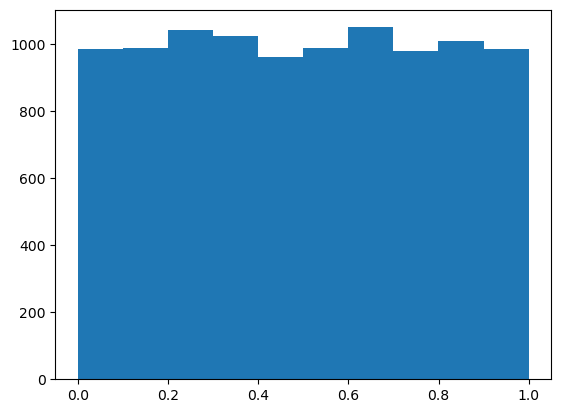

In [96]:
plt.hist([random_number() for _ in range(10000)])

We want to compare the speed difference in our implementation of random number generation and forming a matrix vs PyTorch's.

In [97]:
%timeit -n 10 list(chunks([random_number() for _ in range(7840)], 10))

1.92 ms ± 440 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [99]:
import torch

In [100]:
%timeit -n 10 torch.randn(784,10)

185 µs ± 36.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


We see that our implementation is approximately 1000 times slower!